In [1]:
import numpy as np
import pandas as pd
import os
import time 
import glob
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.listdir('BBC News Summary/Summaries')

['politics', 'sport', 'tech', 'entertainment', 'business']

In [3]:
articles_path = '../input/bbc-news-summary/BBC News Summary/News Articles'
summaries_path = '../input/bbc-news-summary/BBC News Summary/Summaries'
categories_list = ['politics', 'sport', 'tech', 'entertainment', 'business']

In [4]:
def read_files_from_folders(articles_path, summaries_path, categories_list=['tech', 'sport'], encoding = "ISO-8859-1"):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive=True)
        summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive=True)
        
        if len(article_paths) != len(summary_paths):
            print('number of files is not equal')
            return
        for i in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[i], mode='r', encoding = encoding) as file:
                articles.append(file.read())
            
            with open(summary_paths[i], mode='r', encoding = encoding) as file:
                summaries.append(file.read())
    return articles, summaries, categories

In [5]:
articles, summaries, categories = read_files_from_folders(articles_path, summaries_path, categories_list)

In [6]:
df = pd.DataFrame({'articles':articles, 'summaries':summaries, 'categories':categories})
df['articles_length'] = df['articles'].apply(lambda x: len(x.split()))
df['summaries_length'] = df['summaries'].apply(lambda x: len(x.split()))

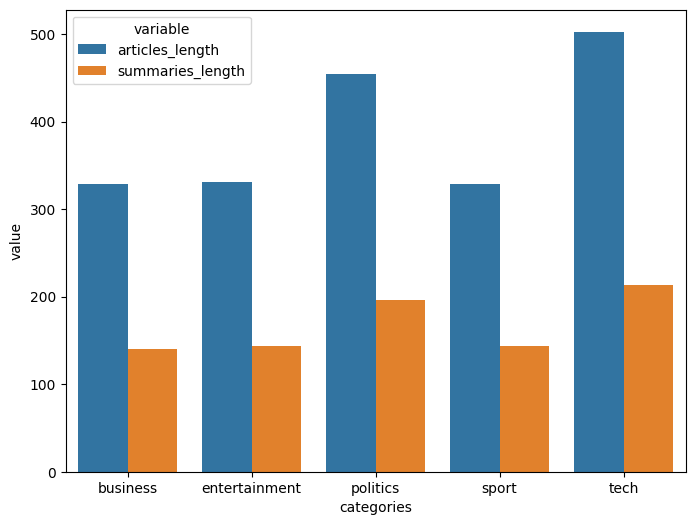

In [7]:
category_length = df.groupby('categories', 0).agg({'articles_length':'mean', 'summaries_length':'mean'})
df_m = pd.melt(category_length, ignore_index=False)
plt.figure(figsize=(8,6))
sns.barplot(x=df_m.index, y="value", hue='variable', data=df_m)
plt.show()

In [8]:
import json
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    AutoTokenizer,
    T5TokenizerFast as T5Tokenizer
)

from tqdm.auto import tqdm
from pylab import rcParams
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
df = df[['articles', 'summaries']]
df['articles'] = df['articles'].str.encode('ascii', 'ignore').str.decode('ascii')
df['summaries'] = df['summaries'].str.encode('ascii', 'ignore').str.decode('ascii')
df = df.dropna()


In [11]:
 train_df, test_df = train_test_split(df, test_size=0.1)

In [12]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        text = data_row['articles']
        text_encoding = tokenizer(
            text,
            max_length = self.text_max_token_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = 'pt'
        )
        summary_encoding = tokenizer(
            data_row['summaries'],
            max_length = self.summary_max_token_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = 'pt'
        )
        
        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100
        
        return dict(
            text = text,
            summary = data_row['summaries'],
            text_input_ids = text_encoding['input_ids'].flatten(),
            text_attention_mask = text_encoding['attention_mask'].flatten(),
            labels = labels.flatten(),
            labels_attention_mask = summary_encoding['attention_mask'].flatten()
        )

In [13]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 4
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 4
        )

In [14]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['articles']))
    text_token_counts.append(text_token_count)
    
    summary_token_count = len(tokenizer.encode(row['summaries']))
    summary_token_counts.append(summary_token_count)

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


In [16]:


N_EPOCHS = 2
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer)

In [17]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels,
            decoder_attention_mask = decoder_attention_mask
        )
        
        return output.loss, output.logits
    
    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        
        loss, output = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        
        loss, output = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        
        loss, output = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [18]:
model = NewsSummaryModel()

# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [19]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger = logger,
    callbacks = [checkpoint_callback],
    max_epochs=N_EPOCHS,
    accelerator="auto",
)

torch.cuda.empty_cache()

In [20]:
trainer.fit(model, data_module)

trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        reurn_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    
    generated_ids = trained_model.model.generate(
        input_ids = text_encoding['input_ids'],
        attention_mask = text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]
    
    return "".join(preds)

In [23]:
def summarizeText(text, trained_model, tokenizer):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
        decoder_start_token_id=trained_model.model.config.pad_token_id
    )

    # Decode the generated summary
    generated_summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_summary


In [25]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Assuming you have trained_model and tokenizer initialized
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to summarize text
def summarize_text(text, model, tokenizer):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(device)
    
    summary_ids = model.generate(
        inputs['input_ids'],
        max_length=150,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True,
        no_repeat_ngram_size=2
    ).to(device)
    
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

sample_row = test_df.iloc[0]
article_text = sample_row['articles']
generated_summary = summarize_text(article_text, trained_model.model, tokenizer)

print("Original Text:")
print(article_text)

print("\nGenerated Summary:")
print(generated_summary)


Original Text:
Cheaper chip for mobiles

A mobile phone chip which combines a modem and a computer processor on one bit of silicon instead of two could make phones cheaper and more powerful.

The specially-designed chip, developed by Texas Instruments, could drive down the cost of making mobiles capable of 3D gaming and 30-frame-a-second video. Currently, rich multimedia features tend to be on more expensive handsets. The technology, OMAP-Vox, is being tested by firms in Europe and Asia and could appear by the end of the year. Texas, which makes computer chips for more than half the world's mobile phones, said it was keen to make multimedia functions like video and gaming more affordable. "We're going to drive them down into meat-and-potatoes phones that have the largest market share," said Doug Rasor, a marketing vice president at Texas. The chip also uses much less power than conventional chips, said Texas, which means less strain on mobile battery life.

More than 50 million people 